def SEIRHD_Model(y, t, N, beta, r_I_to_R, r_I_to_H, r_E_to_I, r_H_to_R, r_H_to_D, p_I_to_H, p_I_to_R, p_H_to_D, p_H_to_R):
    S, E, I, R, H, D = y

    dSdt = -beta * I * S / N
    dEdt = beta* I * S / N - r_E_to_I * E
    dIdt = r_E_to_I * E - (r_I_to_H * p_I_to_H) * I - (r_I_to_R * p_I_to_R * I)
    dRdt = (r_I_to_R * p_I_to_R * I) + (r_H_to_R * p_H_to_R * H)
    dHdt = (r_I_to_H * p_I_to_H * I) - (r_H_to_D * p_H_to_D * H)  - (r_H_to_R * p_H_to_R * H)
    dDdt = r_H_to_D * p_H_to_D * H
    return dSdt, dEdt, dIdt, dRdt, dHdt, dDdt

In [1]:
import sympy
from copy import deepcopy as _d
from mira.metamodel import *
from mira.modeling import Model
from mira.modeling.askenet.petrinet import AskeNetPetriNetModel
from mira.modeling.viz import GraphicalModel

In [2]:
person_units = lambda: Unit(expression=sympy.Symbol('person'))
day_units = lambda: Unit(expression=sympy.Symbol('day'))
per_day_units = lambda: Unit(expression=1/sympy.Symbol('day'))
dimensionless_units = lambda: Unit(expression=sympy.Integer('1'))
per_day_per_person_units = lambda: Unit(expression=1/(sympy.Symbol('day')*sympy.Symbol('person')))

c = {
    'S': Concept(name='S', units=person_units(), identifiers={'ido': '0000514'}),
    'E': Concept(name='E', units=person_units(), identifiers={'apollosv': '0000154'}),
    'I': Concept(name='I', units=person_units(), identifiers={'ido': '0000511'}),
    'R': Concept(name='R', units=person_units(), identifiers={'ido': '0000592'}),
    'H': Concept(name='H', units=person_units(), identifiers={'ido': '0000511'},
                 context={'property': 'ncit:C25179'}),
    'D': Concept(name='D', units=person_units(), identifiers={'ncit': 'C28554'}),
}


N_val = 19_340_000
E_val = 1
I_val = 4

parameters = {
    'beta': Parameter(name='beta', value=0.4, units=per_day_per_person_units()),
    'r_E_to_I': Parameter(name='r_E_to_I', value=0.2, units=per_day_units()),
    'r_I_to_H': Parameter(name='r_I_to_H', value=0.1, units=per_day_units()),
    'p_I_to_H': Parameter(name='p_I_to_H', value=0.2, units=dimensionless_units()),
    'r_I_to_R': Parameter(name='r_I_to_R', value=0.07, units=per_day_units()),
    'p_I_to_R': Parameter(name='p_I_to_R', value=0.8, units=dimensionless_units()),
    'r_H_to_R': Parameter(name='r_H_to_R', value=0.1, units=per_day_units()),
    'p_H_to_R': Parameter(name='p_H_to_R', value=0.88, units=dimensionless_units()),
    'r_H_to_D': Parameter(name='r_H_to_D', value=0.1, units=per_day_units()),
    'p_H_to_D': Parameter(name='p_H_to_D', value=0.12, units=dimensionless_units()),
    'N': Parameter(name='N', value=N_val, units=person_units()),
}


initials = {
    'S': Initial(concept=Concept(name='S'), value=N_val-(E_val+I_val)),
    'E': Initial(concept=Concept(name='E'), value=E_val),
    'I': Initial(concept=Concept(name='I'), value=I_val),
    'R': Initial(concept=Concept(name='R'), value=0),
    'H': Initial(concept=Concept(name='H'), value=0),
    'D': Initial(concept=Concept(name='D'), value=0),
}

observables = {}

In [3]:
S, E, I, R, D, H, N, beta, r_E_to_I, r_E_to_H, r_I_to_H, p_I_to_H, r_I_to_R, p_I_to_R, r_H_to_R, p_H_to_R, r_H_to_D, p_H_to_D = \
    sympy.symbols('S E I R D H N beta r_E_to_I r_E_to_H r_I_to_H p_I_to_H r_I_to_R p_I_to_R r_H_to_R p_H_to_R r_H_to_D p_H_to_D')

In [4]:
t1 = ControlledConversion(subject=c['S'],
                          outcome=c['E'],
                          controller=c['I'],
                          rate_law=S*I*beta / N)
t2 = NaturalConversion(subject=c['E'],
                       outcome=c['I'],
                       rate_law=r_E_to_I*E)
t3 = NaturalConversion(subject=c['I'],
                       outcome=c['R'],
                       rate_law=r_I_to_R*p_I_to_R*I)
t4 = NaturalConversion(subject=c['I'],
                       outcome=c['H'],
                       rate_law=r_I_to_H*p_I_to_H*I)
t5 = NaturalConversion(subject=c['H'],
                       outcome=c['R'],
                       rate_law=r_H_to_R*p_H_to_R*H)
t6 = NaturalConversion(subject=c['H'],
                       outcome=c['D'],
                       rate_law=r_H_to_D*p_H_to_D*H)
templates = [t1, t2, t3, t4, t5, t6]
tm = TemplateModel(
    templates=templates,
    parameters=parameters,
    initials=initials,
    time=Time(name='t', units=day_units()),
    observables=observables,
    annotations=Annotations(name='Evaluation Scenario 1 Base model')
)
AskeNetPetriNetModel(Model(tm)).to_json_file('eval_scenario1_base.json')

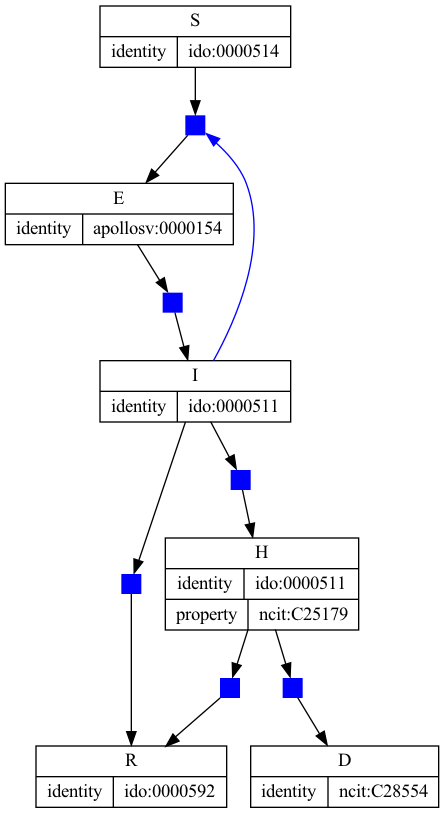

In [5]:
GraphicalModel.for_jupyter(tm)

## Scenario 1/ii
1) Masking Forecasts: For this question, assume that a masking policy will go into place on April 15th, 2020
a) Starting from April 3rd, 2020, forecast the next four weeks of the pandemic (for cases, hospitalizations, and deaths) assuming the following constant levels of masking compliance: 40%, 60%, and 80%. Assume that any person who complies with the masking policy is wearing a surgical mask. How does compliance affect forecasted cases, hospitalizations, and deaths?

(1) Introduce a modification term to β as described in Srivastav et. al. (DOI: 10.3934/mbe.2021010): (1 − 𝜖𝑚𝑐𝑚), where 𝑐𝑚 is the fraction of the population that wear face masks correctly and consistently (i.e. comply with masking policies), and 𝜖𝑚 is the efficacy of the masks themselves.

(2) Adjust the transmission rate following an intervention period and create a time- varying β function, as shown in https://doi.org/10.3390/ijerph18179027

(3) Add compartments and transitions to represent mask wearing/non-mask
wearing populations. See examples for several similar options of representing this addition; you may implement the update in a way that represents one or a combination of these approaches, or has an otherwise analogous effect: https://doi.org/10.1098/rspa.2020.0376, https://doi.org/10.1016/j.idm.2020.04.001, https://doi.org/10.1016/j.chaos.2020.110599, https://doi.org/10.1177/0272989X211019029

In [7]:
eps_m = sympy.Symbol('eps_m')
c_m = sympy.Symbol('c_m')

t1_alt = ControlledConversion(subject=c['S'],
                          outcome=c['E'],
                          controller=c['I'],
                          rate_law=S*I*beta*(1-eps_m*c_m) / N)

parameters['eps_m'] = Parameter(name='eps_m', value=0.5, units=dimensionless_units())
parameters['c_m'] = Parameter(name='c_m', value=0.5, units=dimensionless_units())

tm = TemplateModel(
    templates=[t1_alt, t2, t3, t4, t5, t6],
    parameters=parameters,
    initials=initials,
    time=Time(name='t', units=day_units()),
    observables=observables,
    annotations=Annotations(name='Evaluation Scenario 1. Part 1 (ii) Masking type 1')
)
AskeNetPetriNetModel(Model(tm)).to_json_file('eval_scenario1_1_ii_1.json')